In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import pathlib
from google.colab import files
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2 #14 MB acc Top1 0.71 top5 0.9
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/1st_dataset_cotton/cotton_224x224_split.zip

Archive:  /content/drive/MyDrive/1st_dataset_cotton/cotton_224x224_split.zip
   creating: cotton_224x224_split/
   creating: cotton_224x224_split/test/
   creating: cotton_224x224_split/test/bacterial_blight/
  inflating: cotton_224x224_split/test/bacterial_blight/bact1.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact107.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact108.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact11.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact110.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact142.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact145.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact15.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact154.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact167.png  
  inflating: cotton_224x224_split/test/bacterial_blight/bact175.png  
  inflating: cotton_224x2

In [4]:
EPOCHS=10 #Number of epochs to train the model.
BATCH_SIZE =32
CLASSES=4
PATIENCE=EPOCHS//5
LR_FACTOR=0.2
WEIGHTS_FILE = "weights.h5" #File that stores updated weights
image_size =224 #needs to comply with CNN input constraints.
PATH="/content/cotton_224x224_split" #Path to dataset
TEST_PATH='/content/cotton_224x224_split/test'

In [ ]:
#Necessary data preparation.
def data_prep():
    #Apply data augmentation on-the-fly on the training set to increase generalizability of the model.
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                                shear_range = 0.2,
                                                                zoom_range = 0.2,
                                                                width_shift_range = 0.2,
                                                                height_shift_range = 0.2,
                                                                fill_mode="nearest")
    #Create the pipeline
    train_data = train_datagen.flow_from_directory(os.path.join(PATH,"train"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    # Normalize validation dataset's image rgb values.
    valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
    #Create the pipeline
    valid_data = valid_datagen.flow_from_directory(os.path.join(PATH,"val"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    return[train_data,valid_data]

In [ ]:
#Plot training learning curves for both train and validation.
def plot_training_curves(history):
        #Defining the metrics we will plot.
        train_acc=history.history['accuracy']
        val_acc=history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        #Range for the X axis.
        epochs = range(len(train_loss))

        #Plotting Loss figures.
        fig = plt.figure(figsize=(100,6)) #figure size h,w in inches
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.plot(epochs,train_loss,c="red",label="Training Loss") #plotting
        plt.plot(epochs,val_loss,c="blue",label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        #Plotting Accuracy figures.
        fig = plt.figure(figsize=(100,6)) #figure size h,w in inches
        plt.plot(epochs,train_acc,c="red",label="Training Acc") #plotting
        plt.plot(epochs,val_acc,c="blue",label="Validation Acc")
        plt.xlabel("Epochs")   #title for x axis
        plt.ylabel("Accuracy") #title for y axis
        plt.legend()

In [ ]:
#Make predictions on manually created test dataset folder. (OPTIONAL, different to initial dataset test set)
def test_model(path):
    i=0
    #Inversing class dictionary [keys,values]->[values,keys]
    labels = (train_data.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    for filename in os.listdir(path) :
        i+=1
        file_path= path +"/" + str(pathlib.Path(filename))

        image = tf.keras.preprocessing.image.load_img(
                file_path,grayscale=False, color_mode="rgb",
                target_size=(image_size,image_size), interpolation="nearest")
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr=input_arr/255
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        prediction = model.predict(input_arr)


        a=np.argmax(prediction)
        results = labels[a]


        print("\n")
      # print("Predicted class number :", np.argmax(prediction))
        print("Actual class :" ,pathlib.Path(filename))
        print("predicted class name->  MobileV2:",results )


    print("\n Tested: " ,i, "new unseen images")

In [ ]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
      #Only save the weights that correspond to the minimum validation loss.
      tf.keras.callbacks.ModelCheckpoint(filepath=weights_file,
                                         monitor='val_accuracy',
                                         mode='max',
                                         save_best_only=True ,
                                         save_weights_only=True,
                                         verbose=0),
      #If val_loss doesn't improve for a number of epochs set with 'patience'
      #variable, training will stop to avoid overfitting.
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience,
                                       verbose=1),
      #Learning rate is reduced by 'lr_factor' if val_loss stagnates
      #for a number of epochs set with 'patience/2' variable.
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           factor=lr_factor,
                                           patience=patience//2,
                                           min_lr=1e-6,
                                           verbose=1)]


In [ ]:
#The training class names.
class_names=['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']

In [ ]:
#Create the whole neural network, pass the base model as parameter.
def create_model(base_model):
      x = base_model.output
      #Add a global spatial average pooling layer.
      x = GlobalAveragePooling2D()(x)
      #Add a fully-connected layer.
      x = Dense(1024, activation='relu')(x)
      #Add a dropout layer to decrease overfitting
      x=Dropout(0.2)(x)
      #Add a logistic layer with number_of_neurons=number_of_training_classes.
      predictions = Dense(CLASSES, activation='softmax')(x)

      #This is the model we will train
      model = Model(inputs=base_model.input, outputs=predictions, name="Plant_Disease_Detector")

      #Freeze layers of the base model, we will only train the extra layers.
      #This way features already learned by the base model aren't lost.
      for layer in base_model.layers:
          layer.trainable = False

      #Assign a base learning rate for the Adam optimizer.
      base_learning_rate = 0.0001
      model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)
                    ,loss='categorical_crossentropy' ,metrics='accuracy')

      return model

In [ ]:
#Prepare data
train_data,valid_data=data_prep()
#Define callbacks for training
callbacks=assign_callbacks(WEIGHTS_FILE,PATIENCE,LR_FACTOR)

Found 1400 images belonging to 4 classes.
Found 194 images belonging to 4 classes.


In [ ]:
#Create the base pre-trained model, without the classification layers.
base_model = MobileNetV2(weights='imagenet',
                        include_top=False ,input_shape=(224,224,3))
#Create the complete new model.
model=create_model(base_model)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
#Information about the model's layers.
model.summary()


Model: "Plant_Disease_Detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv

In [ ]:
#Train the model on the dataset.
history=model.fit(x=train_data , batch_size=BATCH_SIZE,
                 epochs=EPOCHS , verbose=2 ,
                 validation_data=valid_data,
                 steps_per_epoch=20,
                 validation_steps=5,
                 callbacks=callbacks)

Epoch 1/10
20/20 - 24s - loss: 1.2033 - accuracy: 0.6266 - val_loss: 0.4642 - val_accuracy: 0.8687 - lr: 0.0010 - 24s/epoch - 1s/step
Epoch 2/10
20/20 - 12s - loss: 0.3144 - accuracy: 0.8906 - val_loss: 0.1633 - val_accuracy: 0.9375 - lr: 0.0010 - 12s/epoch - 618ms/step
Epoch 3/10
20/20 - 11s - loss: 0.2250 - accuracy: 0.9219 - val_loss: 0.1282 - val_accuracy: 0.9563 - lr: 0.0010 - 11s/epoch - 564ms/step
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 - 11s - loss: 0.1497 - accuracy: 0.9422 - val_loss: 0.2527 - val_accuracy: 0.9125 - lr: 0.0010 - 11s/epoch - 566ms/step
Epoch 5/10
20/20 - 12s - loss: 0.1169 - accuracy: 0.9625 - val_loss: 0.1032 - val_accuracy: 0.9688 - lr: 2.0000e-04 - 12s/epoch - 584ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20/20 - 10s - loss: 0.0905 - accuracy: 0.9778 - val_loss: 0.1169 - val_accuracy: 0.9438 - lr: 2.0000e-04 - 10s/epoch - 518ms/step
Epoch 7/10
20/20 

In [ ]:
li=['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']

Following is our prediction:
1/1 [==============================] - 0s 24ms/step


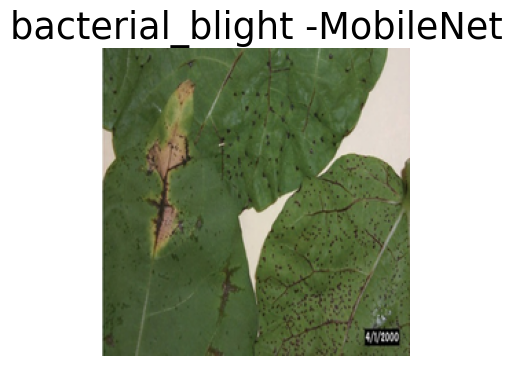

In [ ]:
# predicting an image
from keras.preprocessing import image
import keras.utils as image
import numpy as np
image_path = "/content/cotton_224x224_split/test/bacterial_blight/bact1.png"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name+ " -MobileNet")
plt.show()

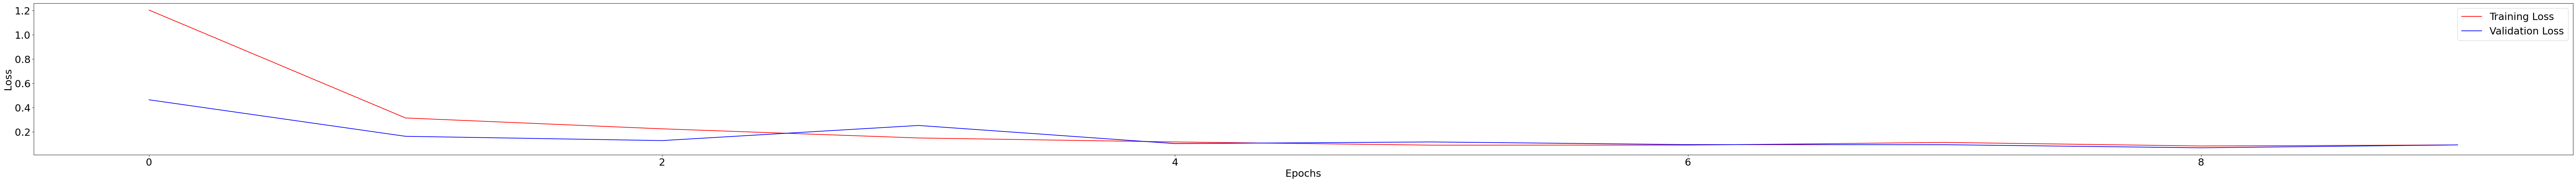

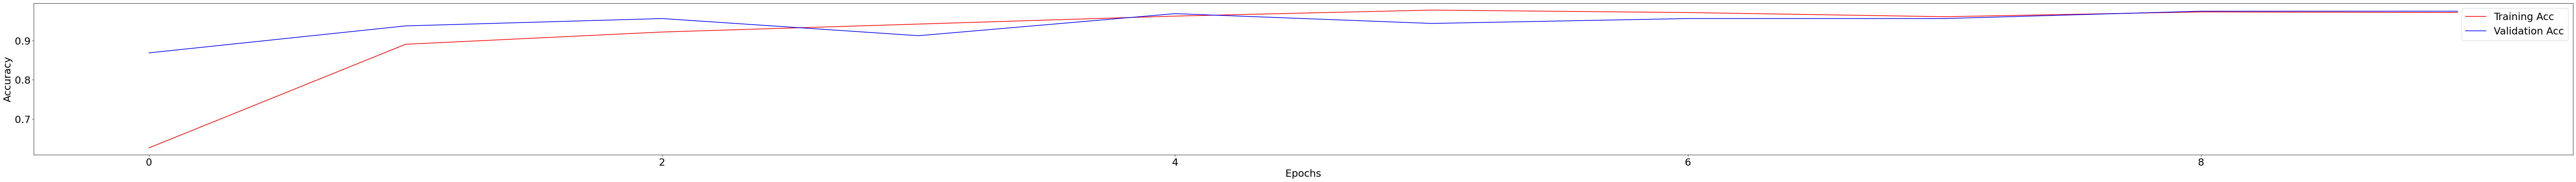

In [ ]:
#Plot the Learning Curves from model training.
plot_training_curves(history)



In [ ]:
#Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
#Convert the model to it's Tensorflow Lite equivalent
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT] ##Quantized
tflite_model = converter.convert()

# Save the model.
with open('model.tfliteQuant', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.save('densenet.h5')